# TP4 :  Learning on a low budget
**Théo Rudkiewicz, Cyriaque Rousselot**

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data samples are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ exists but is not accessible. 
(To make your task easier, we provide you with some data (named `test_dataset` in the code) that you can use to test your model, but you **must not** use it to train your model).

We also assume that we have a limited computational budget.

The goal of this practical session is to guide you through different methods that will help you get better results from few resources (data & compute).

In this practical, we will use the `resnet18` architecture. We will use models from the [pytorch vision hub ](https://pytorch.org/vision/stable/models.html#).

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide 7 files : 
1. This Notebook
2. `utils.py`
3. `last_layer_finetune.pth` (the file **must be of size less than 5Mo**)
4. `daug_resnet.pth` (the file **must be of size less than 50Mo**)
5. `final_model.pth` (the file **must be of size less than 50Mo**)
6. `drawing_lora.png`
7. `cutmix.png`

If the code you defined passes all our tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear and short answers between `<div class="alert alert-info">  <your answer>  </div>` tags (when it's not code).  

<div class="alert alert-info">  Example of answer  </div>

In [1]:
import os

if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("data/TP4_images"):
    os.mkdir("data/TP4_images")
    !cd data/TP4_images && wget -O north_dataset_train.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/yzQRWE2YjmFn9WA/download/north_dataset_train.zip" && unzip north_dataset_train.zip
    !cd data/TP4_images && wget -O north_dataset_test.zip  "https://nextcloud.lisn.upsaclay.fr/index.php/s/zntidWrFdYsGMDm/download/north_dataset_test.zip" && unzip north_dataset_test.zip
dir_path = "data/TP4_images/"


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torchmetrics.classification import BinaryAccuracy, Accuracy, ConfusionMatrix
# you can install torchmetrics with `pip install torchmetrics`


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=transforms.Compose([transforms.ToTensor()]),
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)
base_model = models.resnet18()

## Question 1 : 
>  Change the last layer of the resnet model so that its size fits the problem. 

In [3]:
# Hint 
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
base_model.fc = nn.Linear(in_features = 512, out_features = 2, bias = True)

In [6]:
assert (
    base_model.fc.out_features == 2
)  # we could also change the last layer to have 1 output. Do it with 2 so that it matches our tests procedure during grading.

## Question 2: 
> Train the last layer of a randomly initialized resnet model. Provide a function precompute_features in `utils.py` that creates a new dataset from the features precomputed by the model.

Intermediate question :  Provide the training process in the notebook with training curve. Comment on the accuracy. 

In [164]:
def precompute_features(
    model: models.ResNet, 
    dataset: torch.utils.data.Dataset, 
    device: torch.device
) -> torch.utils.data.Dataset:
    """
    Create a new dataset with the features precomputed by the model.

    If the model is $f \circ g$ where $f$ is the last layer and $g$ is 
    the rest of the model, it is not necessary to recompute $g(x)$ at 
    each epoch as $g$ is fixed. Hence you can precompute $g(x)$ and 
    create a new dataset 
    $\mathcal{X}_{\text{train}}' = \{(g(x_n),y_n)\}_{n\leq N_{\text{train}}}$

    Arguments:
    ----------
    model: models.ResNet
        The model used to precompute the features
    dataset: torch.utils.data.Dataset
        The dataset to precompute the features from
    device: torch.device
        The device to use for the computation
    
    Returns:
    --------
    torch.utils.data.Dataset
        The new dataset with the features precomputed
    """
    dataset_features = []
    model = model.to(device)
    output_feature = []
    def hook_forward(module, input, output):
        output_feature.append(output)
    model.avgpool.register_forward_hook(hook_forward)
    model.eval()
    labels = []
    with torch.no_grad():
        for i in range(len(dataset)):
                input, label = dataset[i][0].to(device), dataset[i][1]
                _ = model(input.unsqueeze(0))
                features = output_feature[-1]
                dataset_features.append(features.flatten().tolist())
                labels.append(label)
    dataset_features = torch.tensor(dataset_features, device = device)
    labels = torch.tensor(labels, device = device, dtype = torch.long)
    return torch.utils.data.TensorDataset(dataset_features, labels)

In [69]:
dataset_features_train = precompute_features(
    base_model, 
    north_dataset, 
    "cuda")
dataset_features_test = precompute_features(
    base_model, 
    test_dataset, 
    "cuda")
print("")

[[0.001619900343939662, 0.25378620624542236, 0.5846346616744995, 0.06858712434768677, 0.12227123230695724, 0.0711062029004097, 1.7031242847442627, 0.10911610722541809, 1.1499571800231934, 0.004387537948787212, 0.6189801096916199, 0.005841570440679789, 0.03863171488046646, 0.3527206778526306, 0.014274700544774532, 0.2886946499347687, 0.7458207011222839, 0.05312208831310272, 1.0477230548858643, 0.3575388789176941, 1.3145939111709595, 0.4823645055294037, 0.40598124265670776, 0.07382897287607193, 1.3976523876190186, 0.043023549020290375, 0.09635326266288757, 0.18528106808662415, 0.6420556306838989, 0.8246657848358154, 0.6392228007316589, 0.39633041620254517, 0.27097031474113464, 0.030901946127414703, 0.28820866346359253, 0.009544714353978634, 0.16072948276996613, 0.1423102617263794, 0.0, 0.07865236699581146, 0.12791764736175537, 0.5777031183242798, 0.16730383038520813, 0.21679851412773132, 0.2698707580566406, 0.04204757884144783, 0.16808636486530304, 0.80909264087677, 0.9425801038742065, 0

In [58]:
from utils import precompute_features
from tqdm import tqdm

In [98]:
batch_size = 16
device = "cuda"
lr = 5e-3
base_model = base_model.to(device)
for param in base_model.parameters():
    param.requires_grad = False

train_loader = torch.utils.data.DataLoader(dataset_features_train, batch_size = batch_size,)
test_loader = torch.utils.data.DataLoader(dataset_features_test, batch_size = batch_size,)
classifier = base_model.fc
for param in classifier.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(classifier.parameters(), lr = lr)
n_epochs = 50
criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
test_accuracies = []
for epoch in tqdm(range(n_epochs)):
    classifier.train()
    
    general_loss = 0
    for x, label in train_loader:
        optimizer.zero_grad()
        predictions = classifier(x)
        loss = criterion(predictions, label)
        loss.backward()
        optimizer.step()
        general_loss += loss.item() 
    train_losses.append(general_loss / len(dataset_features_train))
    general_loss = 0
    test_accuracy = 0
    classifier.eval()
    with torch.no_grad():
        for x, label in test_loader:
            predictions = classifier(x)
            loss = criterion(predictions, label)
            general_loss += loss.item()
            test_accuracy += (predictions.argmax(dim = -1) == label).sum().item()
        test_accuracies.append(test_accuracy / len(dataset_features_test))
    test_losses.append(general_loss / len(dataset_features_test))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 70.59it/s]


In [ ]:
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Evolution of the losses')

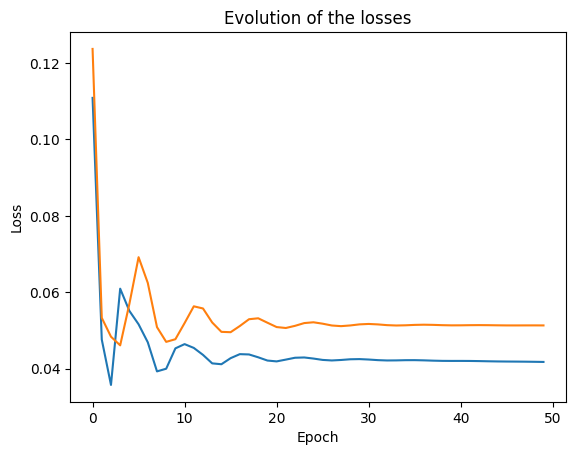

In [100]:
plt.plot(train_losses, label = "Train")
plt.plot(test_losses, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the losses")

Text(0.5, 1.0, 'Evolution of the accuracy')

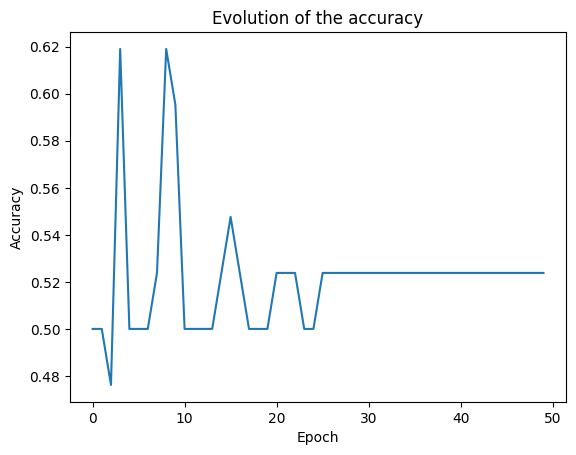

In [101]:
plt.plot(test_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolution of the accuracy")

The accuracy is very bad, because our resnet is not pretarined for our dataset.

<div class="alert alert-info">  Example of answer  </div>

## Question 3 : 
> Now start from a pretained model on Imagenet (https://pytorch.org/vision/stable/models.html#) and only train the last layer. Provide the training process in the notebook with training curve. 

 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `utils.py` containing only the last layer class `LastLayer` inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `last_layer_finetune.pth` file containing __only the last layer weights__ ( we will check the size) 
 
 We will test your model on final accuracy on a test set. 
 

In [133]:
from utils import LastLayer

In [194]:
def train(base_model, train_dataset, test_dataset, device = "cuda", batch_size = 16, lr = 1e-4, n_epochs = 50, criterion_save = "accuracy"):
    
    base_model = base_model.to(device)
    for param in base_model.parameters():
        param.requires_grad = False
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,)
    classifier = base_model.fc
    for param in classifier.parameters():
        param.requires_grad = True
    optimizer = torch.optim.Adam(classifier.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accuracies = []
    min_loss = 1e10
    max_acc = -1
    for epoch in tqdm(range(n_epochs)):
        classifier.train()
        
        general_loss = 0
        for x, label in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            predictions = classifier(x)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            general_loss += loss.item() 
        train_losses.append(general_loss / len(train_dataset))
        general_loss = 0
        test_accuracy = 0
        classifier.eval()
        with torch.no_grad():
            for x, label in test_loader:
                x = x.to(device)
                predictions = classifier(x)
                loss = criterion(predictions, label)
                general_loss += loss.item()                    
                test_accuracy += (predictions.argmax(dim = -1) == label).sum().item()
            test_accuracies.append(test_accuracy / len(test_dataset))
        test_losses.append(general_loss / len(test_dataset))
        if max_acc < test_accuracies[-1] and criterion_save == "accuracy":
            max_acc = test_accuracies[-1]
            torch.save(classifier.state_dict(), "last_layer_finetune.pth")
        elif min_loss > test_losses[-1] and criterion_save == "loss":
            min_loss = test_losses[-1]
            torch.save(classifier.state_dict(), "last_layer_finetune.pth")
    return train_losses, test_losses, test_accuracies

In [195]:
resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()
resnet.fc = fc
dataset_features_train = precompute_features(
    resnet, 
    north_dataset, 
    "cuda")
dataset_features_test = precompute_features(
    resnet, 
    test_dataset, 
    "cuda")


In [196]:
train_loss, test_loss, test_acc = train(resnet, dataset_features_train, dataset_features_test, n_epochs = 100, batch_size = 32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 112.58it/s]


Text(0.5, 1.0, 'Evolution of the losses')

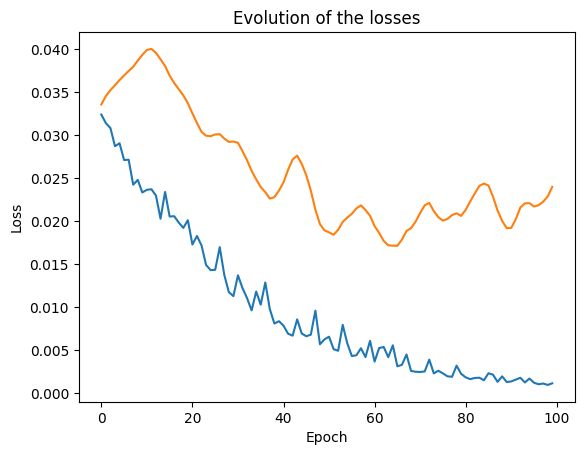

In [197]:
plt.plot(train_loss, label = "Train")
plt.plot(test_loss, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Evolution of the losses")

We overfit at around epoch 40

Text(0.5, 1.0, 'Evolution of the accuracy')

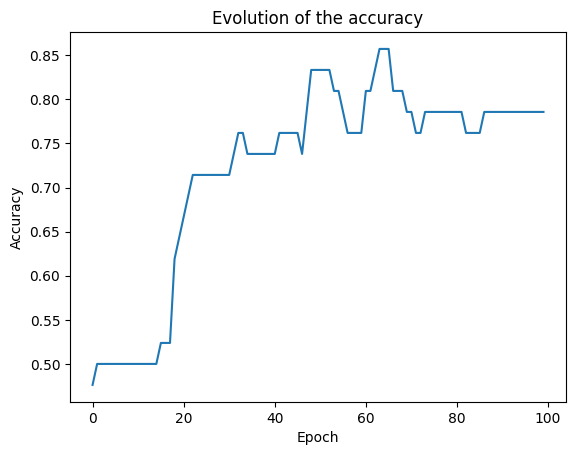

In [198]:
plt.plot(test_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evolution of the accuracy")

Best accuracy is 85 % which is over 20% of accuracy gained compared to the non pretrained resnet.

In [199]:
from utils import LastLayer


resnet = models.resnet18(weights="DEFAULT")
fc = LastLayer()  # !  Important : No argument
fc.load_state_dict(torch.load("last_layer_finetune.pth", weights_only=True))
resnet.fc = fc
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [208]:
def evaluate(model, test_dataset, device = "cuda"):
    
    classifier = model.fc
    classifier.eval()
    classifier = classifier.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16)
    total = 0
    acc = 0
    for x, label in test_loader:
        x = x.to(device)
        predictions = classifier(x)
        acc += (predictions.argmax(dim = -1) == label).sum().item()
        total += len(label)
    acc = acc /total
    return acc

In [209]:
evaluate(resnet, dataset_features_test)

0.8571428571428571

In [228]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Question 4 : 
> Perform  LoRA https://arxiv.org/pdf/2106.09685  on the model  (We are perfectly fine if you use an external library **for this question only**, and of course use it in the next questions). (Warning : without data augmentation it may not improve the accuracy.)

Intermediate question : Describe LoRA. There are different ways of implementing LoRa for convolutions. You can choose your preferred one. Explain the version of LoRa you used, provide a drawing of the process in the `drawing_lora.png` file. (Hint: you can obtain a small rank convolution by combining a convolution and a 1x1 convolution. One of the two goes from a higher number of channels to a lower number of channels and the other one restores the number of channels.)

Answer : LoRA (Low Rank Adaptation) is a method of finetuning that leverages the fact that pretrained models when finetuned have a low intrinsec dimension and still perform well.

Given a weight $W \in \mathbb{R}^{d \times k}$, we fix W that is assumed to be pretrained, and we add in adjunction to it a LoRA Layer that will constraint its update by a low rank decompositoon. This LoRA layer corresponds to two learnable $A \in \mathbb{R}^{d \times r}$ and $B \in \mathbb{R}^{r \times k}$.

The output of the two layers would be :
$h = Wx + BAx$

In [284]:
class LoRALayer(nn.Module):
    def __init__(self, original_layer, r):
        super(LoRALayer, self).__init__()
        self.original_layer = original_layer
        output_channels, input_channels , kernel_size, _, = self.original_layer.weight.shape
        stride = self.original_layer.stride
        padding = self.original_layer.padding
        self.A = nn.Conv2d(input_channels, r, kernel_size = (kernel_size, kernel_size), stride = stride, padding = padding)
        self.B = nn.Conv2d(r, output_channels, kernel_size = (1, 1))
    def forward(self, x):
        
        return self.original_layer(x).detach() + self.B(self.A(x))

In [301]:
resnet = models.resnet18(weights="DEFAULT")
rank = 50
prop_to_keep = 1
for name, module in resnet.named_children():
            if isinstance(module, nn.Conv2d) and torch.rand(1) < prop_to_keep:  # Apply LoRA to Conv2d layers
                setattr(resnet, name, LoRALayer(module, rank))

In [302]:
def train_lora(base_model, train_dataset, test_dataset, device = "cuda", batch_size = 16, lr = 1e-4, n_epochs = 50, criterion_save = "accuracy", weight_decay = 1e-4):
    
    base_model = base_model.to(device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,)
    
    optimizer = torch.optim.Adam(base_model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accuracies = []
    min_loss = 1e10
    max_acc = -1
    for epoch in tqdm(range(n_epochs)):
        base_model.train()
        
        general_loss = 0
        for x, label in train_loader:
            x = x.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            predictions = base_model(x)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            general_loss += loss.item() 
        train_losses.append(general_loss / len(train_dataset))
        general_loss = 0
        test_accuracy = 0
        base_model.eval()
        with torch.no_grad():
            for x, label in test_loader:
                x = x.to(device)
                label = label.to(device)
                predictions = base_model(x)
                loss = criterion(predictions, label)
                general_loss += loss.item()                    
                test_accuracy += (predictions.argmax(dim = -1) == label).sum().item()
            test_accuracies.append(test_accuracy / len(test_dataset))
        test_losses.append(general_loss / len(test_dataset))
        if max_acc < test_accuracies[-1] and criterion_save == "accuracy":
            max_acc = test_accuracies[-1]
            torch.save(base_model.state_dict(), "lora.pth")
        elif min_loss > test_losses[-1] and criterion_save == "loss":
            min_loss = test_losses[-1]
            torch.save(base_model.state_dict(), "lora.pth")
    return train_losses, test_losses, test_accuracies

In [303]:
train_loss, test_loss, test_acc = train_lora(resnet, north_dataset, test_dataset, n_epochs = 200, batch_size = 32, lr = 1e-3, weight_decay = 1e-4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:58<00:00,  3.40it/s]


Text(0, 0.5, 'Loss')

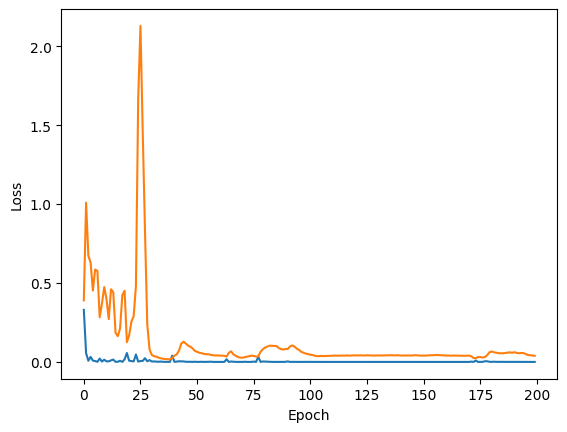

In [308]:
plt.plot(train_loss, label = "Train")
plt.plot(test_loss, label = "Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

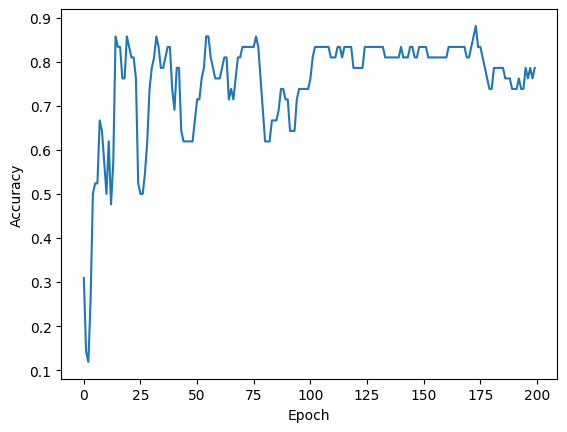

In [309]:

plt.plot(test_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [311]:
print(f"Best accuracy {max(test_acc):.3f}")

Best accuracy 0.881


## Question 5 : 
In order to better train our LORA weights, let's do some Data Augmentation https://en.wikipedia.org/wiki/Data_augmentation . Load some alteration of the data from the `torchvision.transforms` module and incorporate them in your training pipeline.

 Intermediate question : Check CutMix  (https://pytorch.org/vision/stable/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) and explain it with a small drawing `cutmix.png`. 


  Provide one file : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a `daug_resnet.pth` file containing the weight of the ResNet18 after DAUG  (  !  It  has to be of the class ResNet so you have to merge LoRA weights with the ResNet18 weights)

In [329]:
## Data Augmentation
from torchvision.transforms import v2

In [330]:
preproc = v2.Compose([
    
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(0.2, 0.2, 0.1, 0.1),
    v2.RandomVerticalFlip(0.4),
    transforms.ToTensor()
])

In [331]:


north_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_sample",
    transform=preproc,
)
test_dataset = datasets.ImageFolder(
    dir_path + "north_dataset_test",
    transform=transforms.Compose([transforms.ToTensor()]),
)


In [336]:
def train_lora_augmented(base_model, train_dataset, test_dataset, device = "cuda", batch_size = 16, lr = 1e-4, n_epochs = 50, criterion_save = "accuracy", weight_decay = 1e-4):
    NUM_CLASSES = base_model.fc.out_features
    base_model = base_model.to(device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,)
    cutmix = v2.CutMix(num_classes = NUM_CLASSES)
    mixup = v2.MixUp(num_classes = NUM_CLASSES)
    cutmix_mixup = v2.RandomChoice([cutmix, mixup])
    optimizer = torch.optim.Adam(base_model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []
    test_accuracies = []
    min_loss = 1e10
    max_acc = -1
    for epoch in tqdm(range(n_epochs)):
        base_model.train()
        
        general_loss = 0
        for x, label in train_loader:
            x, label = cutmix_mixup(x, label)
            x = x.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            predictions = base_model(x)
            loss = criterion(predictions, label)
            loss.backward()
            optimizer.step()
            general_loss += loss.item() 
        train_losses.append(general_loss / len(train_dataset))
        general_loss = 0
        test_accuracy = 0
        base_model.eval()
        with torch.no_grad():
            for x, label in test_loader:
                x = x.to(device)
                label = label.to(device)
                predictions = base_model(x)
                loss = criterion(predictions, label)
                general_loss += loss.item()                    
                test_accuracy += (predictions.argmax(dim = -1) == label).sum().item()
            test_accuracies.append(test_accuracy / len(test_dataset))
        test_losses.append(general_loss / len(test_dataset))
        if max_acc < test_accuracies[-1] and criterion_save == "accuracy":
            max_acc = test_accuracies[-1]
            torch.save(base_model.state_dict(), "daug_resnet.pth")
        elif min_loss > test_losses[-1] and criterion_save == "loss":
            min_loss = test_losses[-1]
            torch.save(base_model.state_dict(), "daug_resnet.pth")
    return train_losses, test_losses, test_accuracies

In [337]:
lora_model =  models.resnet18(weights="DEFAULT")
rank = 50
prop_to_keep = 1
for name, module in resnet.named_children():
            if isinstance(module, nn.Conv2d) and torch.rand(1) < prop_to_keep:  # Apply LoRA to Conv2d layers
                setattr(resnet, name, LoRALayer(module, rank))
assert isinstance(lora_model, models.ResNet)

In [338]:
train_loss, test_loss, test_acc = train_lora_augmented(lora_model, north_dataset, test_dataset, n_epochs = 200, batch_size = 32, lr = 1e-3, weight_decay = 1e-4)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:29<00:00,  1.34it/s]


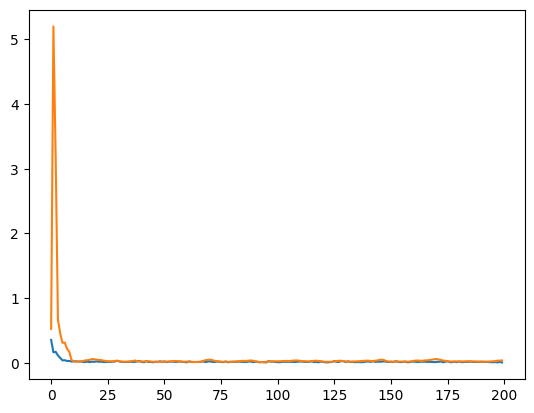

In [342]:
plt.plot(train_loss, label = "train")
plt.plot(test_loss, label = "test")


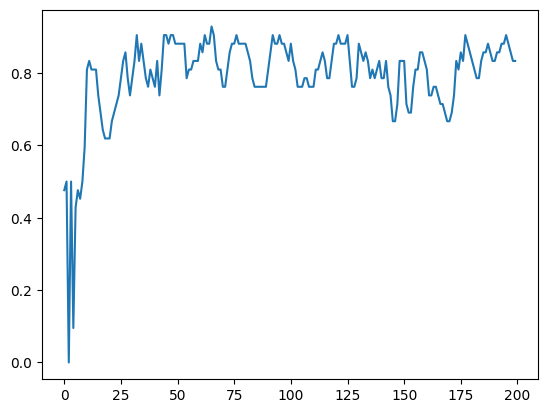

In [343]:
plt.plot(test_acc)

In [344]:
print(f"Accuracy max {max(test_acc)}")

Accuracy max 0.9285714285714286


## Question 6 : (BONUS) 
> Do the best you can : improve performance on test set while keeping ResNet 18 architecture, or decrease the size of the model

Provide a file  `final_model.pth` containing the weights of the final model and provide the class `FinalModel()` in the `utils.py` file. 

In [356]:
sum([p.numel() for p in resnet.layer4.parameters()])

8393728

Layer 4 has 8 million parameters, we could remove it.

In [387]:
class FinalModel(nn.Module):
    def __init__(self):
        super(FinalModel, self).__init__()
        self.resnet =  models.resnet18(weights="DEFAULT")
        self.resnet.layer3 = nn.Identity()
        self.resnet.layer4 = nn.Identity()
        self.resnet.fc = nn.Sequential(nn.Linear(128, 64),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(64, 32),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(32, 2))
    def forward(self, x):
        return self.resnet(x)


In [388]:
resnet = FinalModel().to(device)

In [389]:
criterion_save = "accuracy"
batch_size = 32
n_epochs = 200
weight_decay = 1e-4
train_loader = torch.utils.data.DataLoader(north_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,)
lr = 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()
train_losses = []
test_losses = []
test_accuracies = []
min_loss = 1e10
max_acc = -1
for epoch in tqdm(range(n_epochs)):
    resnet.train()
    
    general_loss = 0
    for x, label in train_loader:
        x = x.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        predictions = resnet(x)
        loss = criterion(predictions, label)
        loss.backward()
        optimizer.step()
        general_loss += loss.item() 
    train_losses.append(general_loss / len(north_dataset))
    general_loss = 0
    test_accuracy = 0
    resnet.eval()
    with torch.no_grad():
        for x, label in test_loader:
            x = x.to(device)
            label = label.to(device)
            predictions = resnet(x)
            loss = criterion(predictions, label)
            general_loss += loss.item()                    
            test_accuracy += (predictions.argmax(dim = -1) == label).sum().item()
        test_accuracies.append(test_accuracy / len(test_dataset))
    test_losses.append(general_loss / len(test_dataset))
    if max_acc < test_accuracies[-1] and criterion_save == "accuracy":
        max_acc = test_accuracies[-1]
        torch.save(resnet.state_dict(), "final_model.pth")
    elif min_loss > test_losses[-1] and criterion_save == "loss":
        min_loss = test_losses[-1]
        torch.save(resnet.state_dict(), "final_model.pth")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:26<00:00,  1.37it/s]


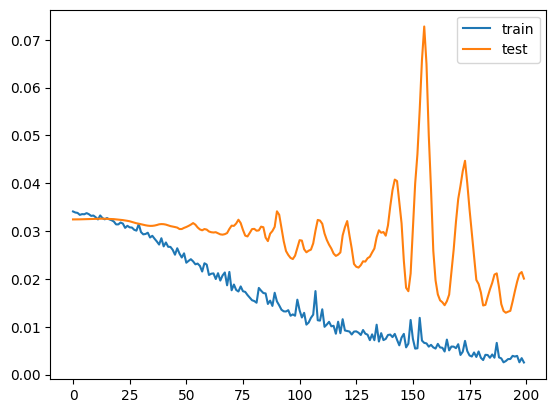

In [390]:
plt.plot(train_losses, label = "train")
plt.plot(test_losses , label = "test")
plt.legend()

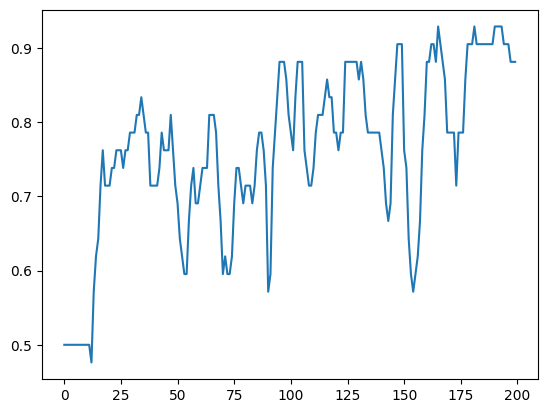

In [401]:
plt.plot(test_accuracies)

In [399]:
print(f"Max accuracy : {max(test_accuracies)}")

Max accuracy : 0.9285714285714286


In [402]:
def evaluate(model, test_dataset, device = "cuda"):
    
    model.eval()
    model = model.to(device)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16)
    total = 0
    acc = 0
    for x, label in test_loader:
        x = x.to(device)
        label = label.to(device)
        predictions = model(x)
        acc += (predictions.argmax(dim = -1) == label).sum().item()
        total += len(label)
    acc = acc /total
    return acc

In [403]:
resnet = FinalModel()
resnet.load_state_dict(torch.load("final_model.pth", weights_only=True))
evaluate(resnet, test_dataset)

0.9285714285714286

In [405]:
print(f"Number of parameters {sum([p.numel() for p in resnet.parameters()])}")

Number of parameters 693474
